<a href="https://colab.research.google.com/github/kcortinas/stackoverflow_2020_survey_gender_analysis/blob/main/Survey_2020_Women_in_Data_Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Stack Overflow Developer Survey 2020 - Women in Data Science

## **1) Data Collection**

In [1]:
# Import libraries and connect with drive to load the data
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
from google.colab import files
import io
import itertools
%matplotlib inline
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
# Load datasets
path_survey = "/content/drive/My Drive/data/survey_results_public.csv"
path_schema = "/content/drive/My Drive/data/survey_results_schema.csv"
df_survey = pd.read_csv(path_survey)
df_schema = pd.read_csv(path_schema)

##**2) Data Cleaning**

In [6]:
# Data cleaning and plotting functions to be used when answering analysis questions

def get_list_possible_values(input_df, column_name):
    '''
    Returns the list of unique values in the column

    INPUT - df - pandas dataframe
            column_name - string - the name of the column you would like to analyse
    OUTPUT - 
            set - set of unique values in the given column
    '''

    # Make sure the column contains a list of values
    input_df[column_name] = input_df[column_name].apply(lambda s: str(s).split(';'))
    
    return set(itertools.chain.from_iterable(input_df[column_name]))

def transform_column_list_values(input_df, column_name):
    '''
    Changes type of a given column: from string to list of values

    INPUT - df - pandas dataframe
            column_name - string - the name of the column you would like to transform
    OUTPUT - 
            df - pandas dataframe with the transformed column
    '''

    # Transform column
    input_df[column_name] = input_df[column_name].apply(lambda s: str(s).split(';'))
    
    return input_df

def get_count_value_in_list_column(input_series):
    '''
    Adds an indicator to the dataframe to indicate the type of job

    INPUT - df - pandas dataframe
            job_column - string - the name of the column containing job information
            job_cue - string - an indicator of the profession, e.g. 'data'
    OUTPUT - 
            df - pandas dataframe with an added indicator for a given type of job
    '''

    return pd.Series([item for sublist in input_series for item in sublist]).value_counts()

def analyse_ratio_men_women_multiple_value_field(input_df, column_name, type_plot):
    '''
    Analyses the ratio of men over women for different values in a multi-value field

    INPUT - input_df - pandas dataframe
            column_name - string - the name of the column containing multi-value info
            type_plot - int - the type of plot to be returned (0: barplot, 1: scatterplot)
    OUTPUT - 
            A plot showing how the ratio of men/women varies for multiple values in the input column
    '''

    # Create dataframes by gender group to compute counts independently
    input_df_men_women = input_df[(input_df.Gender == 'Man') | (input_df.Gender == 'Woman')]
    input_df_men = input_df[input_df.Gender == 'Man']
    input_df_women = input_df[input_df.Gender == 'Woman']

    # Count the amount of individuals in each group informing a given value in the multi-field column
    total_values_series = get_count_value_in_list_column(input_df_men_women[column_name])
    men_values_series = get_count_value_in_list_column(input_df_men[column_name])
    women_values_series = get_count_value_in_list_column(input_df_women[column_name])

    # Aggregate counts for each group in a dataframe and compute ratio of men over women
    df_gender = pd.DataFrame({'total_respondents': total_values_series, 'men': men_values_series, 'women': women_values_series})
    df_gender['ratio_men_women'] = df_gender['men']/df_gender['women']

    if type_plot == 0:
      fig, axs = plt.subplots(1,1, figsize = (16, 16))
      
      # Sort data before plotting
      df_gender_sorted = df_gender.sort_values('ratio_men_women',ascending=False)
      
      # Create palette based on total amount of respondents for each value in the input column
      pal = sns.color_palette("Greens_d", len(df_gender_sorted.total_respondents))
      rank = (df_gender_sorted.total_respondents.rank(ascending = False).astype(int) - 1) # rank values
      
      barplot_gender = sns.barplot(
          data = df_gender_sorted,
          y = df_gender_sorted.index,
          x = df_gender_sorted.ratio_men_women,
          palette=np.array(pal[::-1])[rank]
          )
      
      barplot_gender.set_title('Proportion of men/women for different job types', fontsize = 18)
      plt.show()

    elif type_plot == 1:
      fig, axs = plt.subplots(1,1, figsize = (16, 16))
      scatter_plot_gender = sns.scatterplot(
        data = df_gender_job_type,
        x = 'total_respondents',
        y = 'ratio_men_women',
        color = 'r'
      )
      scatter_plot_gender.set_title('Proportion of men/women for different job types', fontsize = 18)
      plt.show()

    else:
      print("Please indicate the type of plot to be returned: 0 - Barplot, 1 - Scatterplot")

##**3) Analysis**

**1.   Gender diversity in Data Science (DS) as compared to other tech fields: are there more women in DS?**

To assess gender diversity in Data Science as compared to other fields, we'll use the column *DevType*. Since women is a minority group in the survey, to quantify differences between industries we'll use as a metric the ratio of men over women.

Before comparing the ratio on different job types, let's see what the column *DevType* looks like:

In [27]:
get_list_possible_values(df_survey, 'DevType')

{'Academic researcher',
 'Data or business analyst',
 'Data scientist or machine learning specialist',
 'Database administrator',
 'Designer',
 'DevOps specialist',
 'Developer, QA or test',
 'Developer, back-end',
 'Developer, desktop or enterprise applications',
 'Developer, embedded applications or devices',
 'Developer, front-end',
 'Developer, full-stack',
 'Developer, game or graphics',
 'Developer, mobile',
 'Educator',
 'Engineer, data',
 'Engineer, site reliability',
 'Engineering manager',
 'Marketing or sales professional',
 'Product manager',
 'Scientist',
 'Senior executive/VP',
 'System administrator',
 'nan'}

Some respondents didn't inform their job type. Before deciding how to treat missings in the *DevType* column, let's determine what's the missing proportion first:

In [28]:
print(np.round(df_survey[df_survey.DevType.apply(lambda s: 'nan' in s)].shape[0] * 100 / df_survey.shape[0], 2), '%')

23.41 %


While we could impute missings or infer the job type using other predictors via a supervised model, in this case our goal is to understand whether the ratio of men over women is higher or lower in Data Science as compared to other industries. Since the missings correspond to respondents not open to share this information in the survey and we still have almost 80% of values informed, to answer the question of interest we'll only consider the respondents who informed their job type in the questionnaire and drop the missing rows:

In [23]:
df_survey = df_survey[df_survey.DevType.apply(lambda s: 'nan' not in s)]

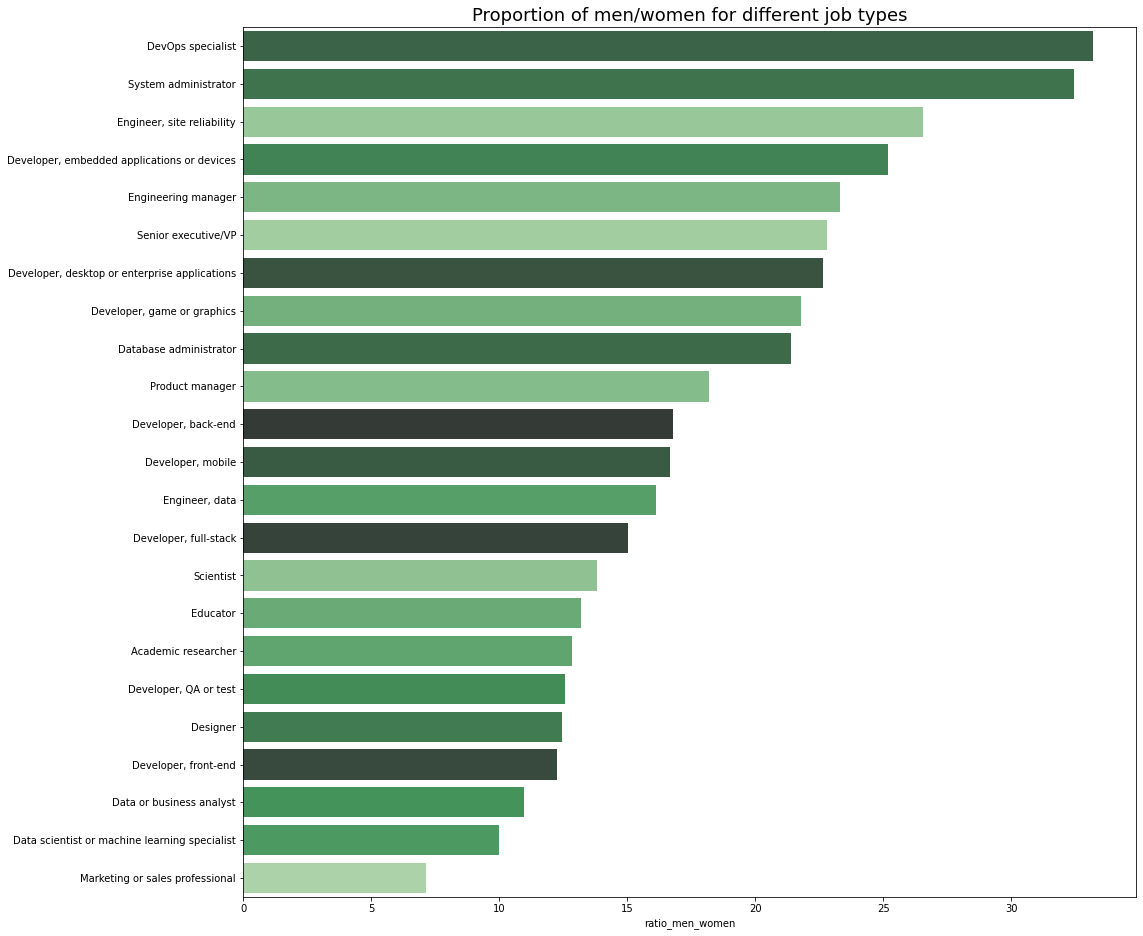

In [24]:
analyse_ratio_men_women_multiple_value_field(df_survey, 'DevType', 0)

Most respondents in the survey are back-end, full-stack or front-end developers (in the graph above the darker the colour, the more respondents). As expected, in any job category there are more men than women: for any woman taking the survey there are on average a minimum of 5 men. Except from data engineering, the ratio of men over women in data job types (data/business analyst, data scientist or ML specialist) is below the average: data professionals are about 10 times more likely to be men than women, while for DevOps specialist or System administrators the ratio is greater than 30.

Data or business analyst, data scientist or machine learning specialist and marketing or sales professionals are the job types where women have greater representation.